# Introduction

In [1]:
%matplotlib inline
import pandas as pd

from typing import Tuple
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

TODO: copy and adjust the introduction
descirbe sampling, outliers managment, etc

In [2]:
dfs = {}
dfs_test = {}
stocks = ['9061', '9062', '9063', '9064', '9065']

for s in stocks:
    d, d_test = lob.load_data(s)
    dfs[s] = d
    dfs_test[s] = d_test

Training set length: 11420
Testing set length: 2864
Training set length: 11558
Testing set length: 2945
Training set length: 10981
Testing set length: 2708
Training set length: 11691
Testing set length: 2961
Training set length: 8458
Testing set length: 2076


In [3]:
dfs['9061'].head()

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-02 10:00:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(690.6, 10409.0), (690.7, 13860.0), (690.8, 1...",690.3,690.6,690.45,10409.0,4222.0,0.0,-0.422869
2013-09-02 10:01:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(690.5, 464.0), (690.6, 4472.0), (690.7, 1491...",690.3,690.5,690.40,464.0,4385.0,0.0,0.808620
2013-09-02 10:02:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(690.4, 3138.0), (690.5, 13259.0), (690.6, 13...",690.2,690.4,690.30,3138.0,4923.0,0.0,0.221437
2013-09-02 10:03:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(690.4, 10805.0), (690.5, 13947.0), (690.6, 1...",690.1,690.4,690.25,10805.0,10083.0,0.0,-0.034565
2013-09-02 10:04:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(689.8, 6903.0), (689.9, 15705.0), (690.0, 41...",689.5,689.8,689.65,6903.0,6937.0,1.0,0.002457


In [4]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []

for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())

df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary.head()

,sum_sell_ask_mean,sum_buy_bid_mean,max_trade_price,min_trade_price,bid_ask_spread
9061,6473.745622,6943.939842,730.2,662.30,0.182688
9062,975.015747,987.934418,3351.0,2937.00,1.027340
9063,8270.532283,7562.345324,487.1,427.40,0.098097
9064,29424.466769,28884.551450,80.8,72.01,0.026835
9065,6459.182076,6542.064081,1684.5,1536.00,0.679298


In [5]:
# TODO: describe results here

# Methodology 

## Sample construction

## In-sample, out-of-sample

## Formulating predictions




In [6]:
reg = {}
reg_svm = {}

for s in stocks:
    reg[s] = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    reg_svm[s] = lob.svm_classification(dfs[s], 0, len(dfs[s]))

In [7]:
pred_in_sample = {}
pred_out_of_sample = {}
for s in stocks:
    pred_in_sample[s] = reg[s].predict(dfs[s]['queue_imbalance'].values.reshape(-1, 1))
    pred_out_of_sample[s] = reg[s].predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    
pred_svm_in_sample = {}
pred_svm_out_of_sample = {}
for s in stocks:
    pred_svm_in_sample[s] = reg_svm[s].predict(dfs[s]['queue_imbalance'].values.reshape(-1, 1))
    pred_svm_out_of_sample[s] = reg_svm[s].predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))

### Density

TODO: describe the plot

To
illustrate why these round-number effects appear strongly for small-tick stocks,
but not for large-tick stocks, we also calculate the empirical cumulative density
functions (ECDFs) of the best-quote queue lengths n b (b(t), t) and n a (a(t), t)
(see Figure 3)

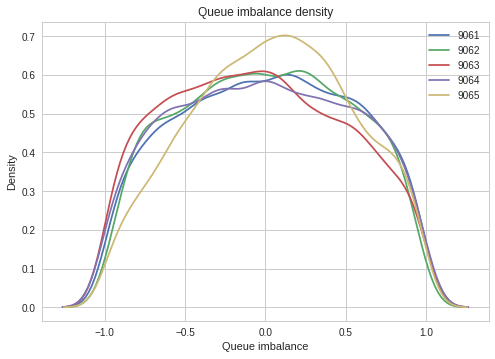

In [8]:
for s in stocks:
    sns.kdeplot(np.array(dfs[s]['queue_imbalance']), label=s)
    #dfs[s]['queue_imbalance'].plot('kde',label=s)


plt.legend()
plt.xlabel('Queue imbalance')
plt.ylabel('Density')
plt.title('Queue imbalance density')

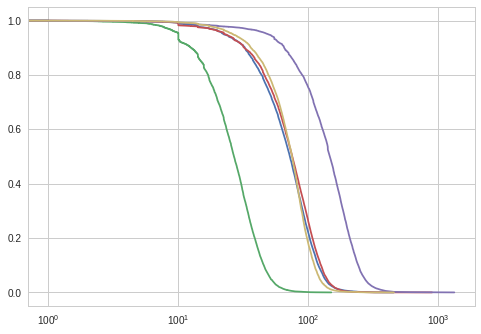

In [9]:

 
    
ax = plt.subplot()
ax.set_xscale("log", basex=100)
for s in stocks:
    ecdf = ECDF(np.array( dfs[s]['sum_buy_bid']))
    
    e = 1 - ecdf.y
    plt.plot(ecdf.x, e)

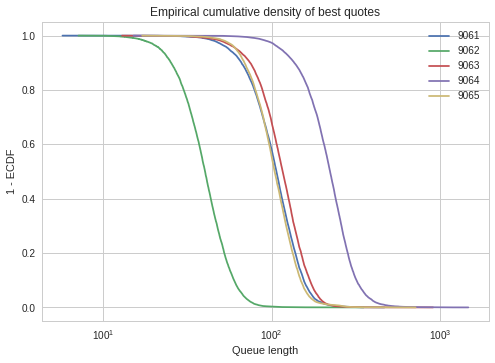

In [10]:
def ecdf(x):
    xs = np.sort(x)
    ys = 1 - np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys
ax = plt.subplot()
ax.set_xscale("log",  basex=100)


for s in stocks:
    ec = ecdf(dfs[s]['sum_sell_ask'].values + dfs[s]['sum_buy_bid'])
    plt.plot(ec[0], ec[1], label=s)
plt.xlabel('Queue length')
plt.ylabel('1 - ECDF')
plt.title('Empirical cumulative density of best quotes')
plt.legend()

## Assessing predictions

To assess the predictive power of our fits for performing binary classification,
we calculate the out-of-sample receiver operating characteristic (ROC) curves
and the corresponding area-under-ROC-curve statistics. The area under the
ROC curve quantifies how successfully the logistic regression fits classify cases
that result in a price move of a given direction. More precisely, for a given queue
imbalance I i 0 chosen uniformly at random among all observations for which
y i = 1 and another queue imbalance I j 0 chosen uniformly at random among all
observations for which y i = 0, the area under the ROC curve is equal to the
probability that the resulting values of ŷ will satisfy ŷ i 0 > ŷ j 0 .

## Local logistic regression / SVM

In [11]:
df_reg = pd.DataFrame(index=stocks)
x1 = []
x0 = []
for s in stocks:
    x1.append(reg[s].coef_[0][0])
    x0.append(reg[s].intercept_[0])
df_reg['x1'] = x1
df_reg['x0'] = x0
df_reg.head()

,x1,x0
9061,0.431416,-0.032502
9062,0.336716,0.025546
9063,0.557622,0.036672
9064,0.365093,0.023537
9065,0.602451,0.005641


In [12]:
# TODO: x0 is small describe

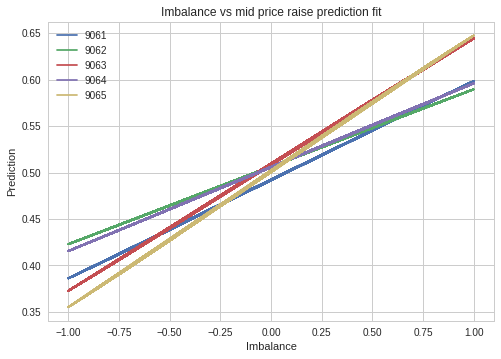

In [13]:
for s in stocks:
    plt.plot(dfs[s]['queue_imbalance'].values, 
             lob.sigmoid(reg[s].coef_[0] * dfs[s]['queue_imbalance'].values + reg[s].intercept_), '-', label=s)
plt.title('Imbalance vs mid price raise prediction fit')
plt.xlabel('Imbalance')
plt.ylabel('Prediction')
plt.legend()

In [14]:
from sklearn.metrics import classification_report
for s in stocks:
    print(s)
    print(classification_report(pred_in_sample[s], dfs[s]['mid_price_indicator']))

9061
             precision    recall  f1-score   support

        0.0       0.58      0.55      0.57      6073
        1.0       0.52      0.55      0.53      5347

avg / total       0.55      0.55      0.55     11420

9062
             precision    recall  f1-score   support

        0.0       0.49      0.54      0.51      5218
        1.0       0.59      0.54      0.56      6340

avg / total       0.54      0.54      0.54     11558

9063
             precision    recall  f1-score   support

        0.0       0.56      0.56      0.56      5488
        1.0       0.56      0.57      0.57      5493

avg / total       0.56      0.56      0.56     10981

9064
             precision    recall  f1-score   support

        0.0       0.51      0.54      0.52      5431
        1.0       0.58      0.54      0.56      6260

avg / total       0.54      0.54      0.54     11691

9065
             precision    recall  f1-score   support

        0.0       0.52      0.56      0.54      3872
        

In [15]:
### Assesing predictivity power

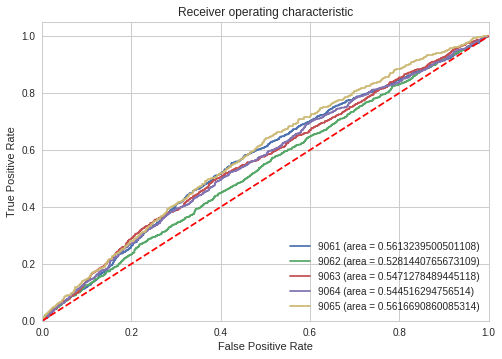

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

for s in stocks:
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_out_of_sample[s])
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, 
                                     reg[s].predict_proba(dfs_test[s]['queue_imbalance'].reshape(-1, 1))[:,1])
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

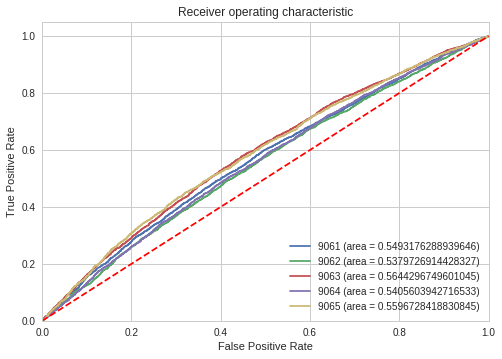

In [17]:
# in sample
for s in stocks:
    logit_roc_auc = roc_auc_score(dfs[s]['mid_price_indicator'], pred_in_sample[s])
    fpr, tpr, thresholds = roc_curve(dfs[s]['mid_price_indicator'].values, 
                                     reg[s].predict_proba(dfs[s]['queue_imbalance'].reshape(-1, 1))[:,1])
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [18]:
for s in stocks:
    print(((dfs_test[s]['mid_price_indicator'] - pred_out_of_sample[s]) ** 2).mean())

0.43889664804469275
0.47198641765704585
0.4531019202363368
0.4552516041877744
0.43834296724470134


In [19]:
for s in stocks:
    print(((dfs_test[s]['mid_price_indicator'].values - reg[s].predict_proba(
        dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))[:,1]) ** 2).mean())

0.246832824185
0.249418774515
0.247445450073
0.247289396377
0.244477388979


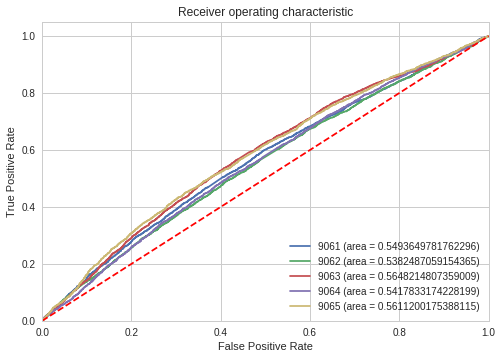

In [20]:
for s in stocks:
    logit_roc_auc = roc_auc_score(dfs[s]['mid_price_indicator'], pred_svm_in_sample[s])
    fpr, tpr, thresholds = roc_curve(dfs[s]['mid_price_indicator'].values, 
                                     reg_svm[s].predict_proba(dfs[s]['queue_imbalance'].reshape(-1, 1))[:,1])
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [21]:
for s in stocks:
    print(s)
    print(classification_report(pred_svm_in_sample[s], dfs[s]['mid_price_indicator']))

9061
             precision    recall  f1-score   support

        0.0       0.62      0.55      0.58      6552
        1.0       0.48      0.55      0.51      4868

avg / total       0.56      0.55      0.55     11420

9062
             precision    recall  f1-score   support

        0.0       0.50      0.53      0.52      5389
        1.0       0.57      0.54      0.56      6169

avg / total       0.54      0.54      0.54     11558

9063
             precision    recall  f1-score   support

        0.0       0.55      0.56      0.56      5325
        1.0       0.58      0.57      0.57      5656

avg / total       0.57      0.56      0.56     10981

9064
             precision    recall  f1-score   support

        0.0       0.49      0.54      0.52      5269
        1.0       0.59      0.54      0.57      6422

avg / total       0.55      0.54      0.54     11691

9065
             precision    recall  f1-score   support

        0.0       0.55      0.55      0.55      4152
        